# ELEC 400M / EECE 571M Assignment 2: Neural networks
(This assignment is a modified version of an assignment used in ECE 421 at the University of Toronto and kindly made available to us by the instructor.)

In this assignment, you will implement a neural network model for multi-class classification. The purpose is to demonstrate an understanding of the basic elements including training of neural network models. Hence, your implementation will be from scratch only using functions from the NumPy library.

The neural network you will be implementing has the following structure:
* 3 layers: 1 input layer, 1 hidden layer with ReLU activation and 1 output layer with Softmax function 􏴣 
* The loss function is the Cross Entropy Loss.
* Training will be done using Gradient Descent with Momentum. 

## Data Set
We again consider the dataset of images of letters in different fonts contained in file notMNIST.npz (which btw is from http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html). This time we consider 10 letters ("A" to "J"), which are all the letters contained in this data set, and we want to classfiy the images according to the letter they display. The figure below shows 30 randomly selected image samples for the letters.

![](sample_images_2.eps)


You will apply the function `loadData` given below to load the data set, which includes 18720 images and their labels, which we also refer to as targets. This script organizes the data set into training, validation and test sets. 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def loadData():
    with np.load('notMNIST.npz') as data:
        Data, Target = data['images'], data['labels']
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx]/255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:15000], Target[:15000]
        validData, validTarget = Data[15000:16000], Target[15000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
       
    return trainData, validData, testData, trainTarget, validTarget, testTarget

## Data preprocessing [5 points]

Input data: The classification should be based on the $d=28\times 28=784$ intensity values in an image (as for Assignment 1).

Output data: Since you will be performing multi-class classification, the labels will be converted into a one-hot encoding format. 

Please first briefly explain the meaning of one-hot encoding and why it is used (instead of keeping the numerical label values provided by the data set). State an example for a one-hot encoded label for the data set considered in this assignment.

Answer:

A one-hot encoding is a representation of target labels as binary vectors.

The labels must first be mapped to integer values. In this case, the letters are mapped to the sequence they are indexed in the alphabet. A = 0, B = 1, C = 2 ... J = 9.

Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1. The 1 is the "hot" value.

One-hot is used in machine learning so that the machine can work with ordinal or categorical data. 

One example for this data set: A: Target = 0; One-hot = [1,0,0,0,0,0,0,0,0,0];

Now implement a function that one-hot encodes the labels (or targets) for the training, validation and test sets. 

In [6]:
def convertOneHot(trainTarget, validTarget, testTarget):
    newTrainTarget = np.zeros((trainTarget.shape[0], 10))
    newValidTarget = np.zeros((validTarget.shape[0], 10))
    newTestTarget = np.zeros((testTarget.shape[0], 10))
    
    #loop through train, test, and valid targets
    for item in range(0, trainTarget.shape[0]):
        newTrainTarget[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newValidTarget[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newTestTarget[item][testTarget[item]] = 1
    return newTrainTarget, newValidTarget, newTestTarget

#assign targets as one-hot
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
TrainTarget, ValidTarget, testTarget = convertOneHot(trainTarget, validTarget, testTarget)


#confirm shape
print(trainData.shape)


(15000, 28, 28)


## Structure of the network [2 points]

Sketch the structure of the network to classify the letters from the data set. Identify the dimensions of the network layers, include the activation functions, and do not forget the bias nodes. (You may sketch this by hand and upload a photo of your sketch.)

Answer:

Please find the diagram attached to this repository if not being displayed here below. I've been having problems uploading pictures into the JupyterHub repository. All the diagrams in this assignment have also been uploaded to Google Drive, which can be found here:

https://drive.google.com/open?id=1hVfllsCnZKxbo9pf_uatfMKBwXMyhV4W

Network Diagram for 1000 Hidden Nodes:

Please refer to the diagram in the submission repository if graph is not displaying here.

![network_diagram]("network_diagram.png![network_diagram.png]")
(network_diagram.png)

If it isn't in the repo, please see the diagram I uploaded in the Google Drive link.

Diagram: https://drive.google.com/open?id=1R-ayCAbJ5RmQTDYc-amQVsDfgAvWCOdS

Google Drive for Diagrams: https://drive.google.com/open?id=1hVfllsCnZKxbo9pf_uatfMKBwXMyhV4W

## Helper functions [6 points]
To give the implementation of the network some structure, you will first implement five helper functions. 

Use Numpy arrays for your implementations, and organize data in vectors and matrices as appropriate for compact programming.

1. `relu`: This function will accept one argument and return the ReLU activation: 
    $$\mathrm{ReLU}(x)=\max(0,x).$$
    
2. `softmax`: This function will accept one argument and return the softmax activations:
    $$ [\sigma(\mathbf{z})]_j = \frac{\mathrm{e}^{z_j}}{\sum\limits_{k=1}^K\mathrm{e}^{z_k}},$$ $j=1,2,\ldots, K$,  for $K$ classes.

3. `computeLayer`: This function will accept two arguments, the input vector $\mathbf{x}$ for a layer and the weight matrix $\mathbf{W}$, and return a vector $\mathbf{s}=\mathbf{W}^T\mathbf{x}$, i.e., the input to the activation function of the layer (the notation for variables from the textbook is used). Don't forget to account for the bias term (which can be included in an augmented vector $\mathbf{x}$ as in the textbook).

4. `CE`: This function will accept two arguments, the one-hot encoded labels $\mathbf{y}_n$ and the inputs $\mathbf{s}_n$ to the softmax function, $n=1,2,\ldots N$. It will return the cross entropy loss
$$\mathrm{E}_{\mathrm{in}}=-\frac{1}{N}\sum\limits_{n=1}^N\sum\limits_{k=1}^Ky_{n,k}\log([\sigma(\mathbf{s}_n)]_k)$$

5. `gradCE`: This function will accept two arguments, the labels and the inputs to the softmax function. It will return the gradient of the cross entropy loss with respect to the inputs (i.e., it returns the sensivity vector for the output layer as introduced in the textbook). 

First state the analytical expression for the gradient used in `gradCE` and then implement the five helper functions.

Answer:

The following is the analytical expression for the average gradient used in gradCE:

$$\frac{\partial (CE)}{\partial \mathbf{\underline x}} = -\frac{1}{N}\sum\limits_{n \epsilon N}\sum\limits_{k \epsilon K} (t_{k}^{(n)} \cdot \frac{1}{x_{k}^{(n)}})$$

In this expression, the term $\underline t$ is the target and the term $\underline x$ is the softmax of the predictions.


In [7]:
def relu(x):
    return np.maximum(x, 0)

def grad_relu(x):
    return (1 * (x > 0))

In [8]:
def softmax(x):    
    return np.exp(x)/(np.sum(np.exp(x), axis = 1, keepdims = True))

In [9]:
def computeLayer(x,W):
    return np.matmul(x, W)

In [10]:
def CE(target, prediction):
    return -1 * (np.mean(np.sum(target * np.log(softmax(prediction)), axis = 1)))

In [11]:
def gradCE(target, prediction):
    return prediction - target

def gradCE_softmax(target, prediction):
    return -1 * ((target - softmax(prediction)) / len(target))

## Backpropagation [2 points]

The training of the network will be done via backpropagation. First derive the following gradients:
1. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{o}}}$, where $\mathbf{W}^{\mathrm{o}}$ is the weight matrix of the output layer.

2. $\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{h}}}$, where $\mathbf{W}^{\mathrm{h}}$ is the weight matrix of the hidden layer.

Write the results using the steps and notation used in the textbook.

Answer:

#1. 

Result after derivation: 

$$\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{o}}} = -\frac{1}{N}\cdot\underline{x}^h\cdot(\underline{t}^L - \underline{x}^L)^T$$

$$\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{b_o}} = -\frac{1}{N}\cdot\underline{1}^h\cdot(\underline{t}^L - \underline{x}^L)^T$$

#2. 

Result after derivation:

$$\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{h}}} = \underline{x}^o \cdot ((W_o \cdot (\delta^L)^T) \bigotimes\theta^\prime (\underline{s}^h))^T$$

$$\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}^{\mathrm{h}}} = \underline{1}^o \cdot ((W_o \cdot (\delta^L)^T) \bigotimes\theta^\prime (\underline{s}^h))^T$$

where $\theta^\prime ({s_i}^h$): 

= 1 if (${s_i}^h$ > 0); 

= 0 else


## Network training [8 points]

Implement a function to train the network. The function uses the helper functions from above. The optimization technique for backpropagation will be Gradient Descent with Momentum:
$$\mathbf{V}(t)=\alpha \mathbf{V}(t-1)-\eta\frac{\partial E_{\mathrm{in}}}{\partial \mathbf{W}(t)}$$
and 
$$\mathbf{W}(t+1)=\mathbf{W}(t)+\mathbf{V}(t),$$
where $\eta$ is the learning rate and $\alpha$ is the momentum hyperparameter.

The training function accepts the following inputs:  training data (features), training labels, weight matrix of the hidden layer, weight matrix of the output layer, number of iterations, parameters $\eta$ and $\alpha$, validation data, validation labels, test data, test labels. The validation and test inputs are initialized to "None" and need not be passed on. You will also need to initialize the velocity matrices $\mathbf{V}$ for both hidden layer and output layer weights to small values, e.g. $10^{-5}%$.

The function outputs the updated weight matrices, the losses and classification accuracies for the training data, and if validation and test inputs were provided, then it also outputs the classification accuracies for the validation and test data.

In [12]:
def forward_propagate(data_input, w_hid, w_out):
    
    #propagate through relu and softmax
    z1 = computeLayer(data_input, w_hid)
    
    a1 = relu(z1)
    a1 = np.insert(a1, 0, np.ones(a1.shape[0]), axis = 1)
    
    z2 = computeLayer(a1, w_out)
    a2 = softmax(z2) 

    return z1, a1, z2, a2

def back_propagate(data_input, target, z1, a1, a2, w_out):
    
    #take softmax gradient
    softmax_grad = gradCE(target, a2)
    
    #output gradient
    grad_w_out = np.matmul(a1.T, softmax_grad)

    #hidden gradient
    grad_hid = np.multiply(grad_relu(z1), np.matmul(softmax_grad, w_out[1:].T))
    
    #hidden gradient
    grad_w_hid = np.matmul(data_input.T, grad_hid)
    
    return grad_w_out, grad_w_hid

def network_training(data_in, target_in, w_hid, w_out, iterations, learning_rate, alpha, v_out, v_hid):
    
    #initialize lists to track accuracy and loss
    accuracy_train, accuracy_valid, accuracy_test = [], [], []
    loss_train, loss_valid, loss_test = [], [], []
    
    print("###### TRAINING BEGINNING #######")
    print("     ")
    
    for i in range(iterations):
        
        ###
        #forward prop
        z1, a1, z2, a2 = forward_propagate(data_in[0], w_hid, w_out)
        
        #train accuracy
        accuracytrain = np.mean(np.argmax(a2, axis = 1) == np.argmax(target_in[0], axis = 1))
        accuracy_train.append(accuracytrain)
        
        #train loss
        losstrain = CE(target_in[0], a2)
        loss_train.append(losstrain)
        dw_out, dw_hid = back_propagate(data_in[0], target_in[0], z1, a1, a2, w_out)
        ###
        
        ###
        #momentum equations
        v_hid = (v_hid * alpha) - (learning_rate * dw_hid)
        w_hid = (w_hid + v_hid)
        
        v_out = (v_out * alpha) - (learning_rate * dw_out)
        w_out = (w_out + v_out)
        ###
        
        #forward prop for validation and test data
        
        ###
        #forward prop validation
        z1, a1, z2, a2 = forward_propagate(data_in[1], w_hid, w_out)
        #validation accuracy
        accuracyvalid = np.mean(np.argmax(a2, axis = 1) == np.argmax(target_in[1], axis = 1))
        accuracy_valid.append(accuracyvalid)
        #validation loss
        lossvalid = CE(target_in[1], a2)
        loss_valid.append(lossvalid)
        
        ###
        #forward prop test
        z1, a1, z2, a2 = forward_propagate(data_in[2], w_hid, w_out)
        #test accuracy
        accuracytest = np.mean(np.argmax(a2, axis = 1) == np.argmax(target_in[2], axis = 1))
        accuracy_test.append(accuracytest)
        #test loss
        losstest = CE(target_in[2], a2)
        loss_test.append(loss_test)
        ###
        
        ###
        #print data and updates
        print('Epoch: {:.0f} of {:.0f} || Train Accuracy: {:.4f} % || Validation Accuracy: {:.4f} % || Test Accuracy: {:.4f} %'.format(i+1, iterations, accuracytrain*100, accuracyvalid*100, accuracytest*100))
        print('Train Loss: {:.4f} || Validation Loss: {:.4f} || Test Loss: {:.4f}'.format(losstrain, lossvalid, losstest))
        print("     ")
        ###
        
    print("###### TRAINING COMPLETED #######") 
    
    return accuracy_train, accuracy_valid, accuracy_test, dw_out, dw_hid, loss_train, loss_valid, loss_test

## Network test [4 points]

Write a script that constructs the neural network.

Initialize your weight matrices by drawing the elements i.i.d. at random from a zero-mean Gaussian distribution with variance equal to $$\sigma_w^2=\frac{2}{\mbox{# of input nodes + # of output nodes}}$$ (Xavier normalization http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) 

Build a network with 1000 hidden units and train it for 200 epochs using $\alpha=0.9$ and $\eta=10^{-5}$. Plot the training, validation and testing accuracy curves. State the training, validation and testing accuracies after training. Show the plot and the accuracies in the next markdown cell.

In [ ]:
import time

trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

trainData = trainData.reshape((trainData.shape[0], 784))
trainData = np.insert(trainData, 0 ,np.ones(trainData.shape[0]), axis = 1)

validData = validData.reshape((-1, 784))
validData = np.insert(validData, 0 ,np.ones(validData.shape[0]), axis = 1)
testData = testData.reshape((-1, 784))
testData = np.insert(testData, 0 ,np.ones(testData.shape[0]), axis = 1)

###Convert one hot
TrainTarget, ValidTarget, TestTarget = convertOneHot(trainTarget, validTarget, testTarget)
data_in = (trainData, validData, testData)
target_in = (TrainTarget, ValidTarget, TestTarget)

n_x = trainData.shape[1]
n_h = 1000 #hiddenlayers
n_o = 10 #output layers

#standard deviation
stdev1 = np.sqrt(2/(n_x + n_h))
stdev2 = np.sqrt(2/(n_h + n_o))
w_hid = np.random.normal(loc = 0, scale = stdev1, size = (n_x, n_h))
w_out = np.random.normal(loc = 0, scale = stdev2, size = (n_h + 1, n_o))

###
#parameters
num_iterations = 200
eta = 1e-5
alpha = 0.9

###

#time start
time_start = time.time()

#def network_training(Data, Target,
#                    w_hid, w_out, 
#                     iterations, learning_rate, alpha,  
#                     v_out, v_hid):

#train the network
accuracy_train, accuracy_valid, accuracy_test, dw_out, dw_hid, loss_train, loss_valid, loss_test = network_training(data_in, target_in,
                                                                     w_hid, w_out, 
                                                                     num_iterations, eta, alpha, 1e-5, 1e-5)
#time stop
time_stop = time.time()

#print time it took
print("Training Time: {}mins".format((time_stop - time_start) / 60))

#plot accuracy
plt.figure()
plt.subplot(211)
plt.plot(accuracy_train)
plt.plot(accuracy_valid)
plt.plot(accuracy_test)

acc_legend = plt.legend([accuracy_train, accuracy_valid, accuracy_test], ["Train Acc.", "Valid Acc.", "Test Acc."])
plt.title("Accuracy vs. Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")

#plot loss
plt.subplot(212)
plt.plot(loss_train)
plt.plot(loss_valid)
plt.plot(loss_test)

loss_legend = plt.legend([loss_train, loss_valid, loss_test], ["Train Loss", "Valid Loss", "Test Loss"])
plt.title("Loss vs. Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.show()

#1000 hidden units
#9 output nodes
#in_nodes = len(trainData) + 1
#out_nodes = 10

#200 epochs
#alpha = 0.9
#eta = 0.1 #10**-5 
#num_iterations = 200
#hidden_units = 1000

########FIX THE FUNCTION INPUT PARAMETERS - DO THIS LATER
#######PUT WEIGHTS INTO FUNCTION, INIT IN THIS BLOCK
#######PLOT THE TRAINING AND VALIDATION AND TEST ACCURACY CURVES
#RUN THE MODEL ON ALL 3 DATA SETS
#PLOT ACCURACY CURVES AND STATE THE ACCURACIES

#PLOT THE ACCURACY TOTAL, WHICH IS RETURNED FROM TRAINNEURALNETWORK FUNCT



###### TRAINING BEGINNING #######
     
Epoch: 0 of 200 || Train Accuracy: 12.5600 % || Validation Accuracy: 28.8000 % || Test Accuracy: 29.9192 %
Train Loss: 2.2999 || Validation Loss: 2.2412 || Test Loss: 2.2360
     
Epoch: 1 of 200 || Train Accuracy: 29.1867 % || Validation Accuracy: 46.5000 % || Test Accuracy: 46.8429 %
Train Loss: 2.2390 || Validation Loss: 2.0917 || Test Loss: 2.0878
     
Epoch: 2 of 200 || Train Accuracy: 48.1800 % || Validation Accuracy: 55.0000 % || Test Accuracy: 55.1395 %
Train Loss: 2.0820 || Validation Loss: 1.9834 || Test Loss: 1.9792
     
Epoch: 3 of 200 || Train Accuracy: 54.1933 % || Validation Accuracy: 60.3000 % || Test Accuracy: 62.0411 %
Train Loss: 1.9814 || Validation Loss: 1.8892 || Test Loss: 1.8788
     
Epoch: 4 of 200 || Train Accuracy: 60.4533 % || Validation Accuracy: 75.1000 % || Test Accuracy: 76.4317 %
Train Loss: 1.8881 || Validation Loss: 1.7921 || Test Loss: 1.7872
     
Epoch: 5 of 200 || Train Accuracy: 75.5067 % || Validation A

Epoch: 46 of 200 || Train Accuracy: 91.9067 % || Validation Accuracy: 91.1000 % || Test Accuracy: 90.7122 %
Train Loss: 1.5811 || Validation Loss: 1.5845 || Test Loss: 1.5885
     
Epoch: 47 of 200 || Train Accuracy: 91.9600 % || Validation Accuracy: 91.2000 % || Test Accuracy: 90.6021 %
Train Loss: 1.5801 || Validation Loss: 1.5840 || Test Loss: 1.5878
     
Epoch: 48 of 200 || Train Accuracy: 91.9733 % || Validation Accuracy: 91.1000 % || Test Accuracy: 90.6388 %
Train Loss: 1.5792 || Validation Loss: 1.5835 || Test Loss: 1.5873
     
Epoch: 49 of 200 || Train Accuracy: 92.0000 % || Validation Accuracy: 91.1000 % || Test Accuracy: 90.7122 %
Train Loss: 1.5784 || Validation Loss: 1.5830 || Test Loss: 1.5868
     
Epoch: 50 of 200 || Train Accuracy: 92.1333 % || Validation Accuracy: 91.1000 % || Test Accuracy: 90.7489 %
Train Loss: 1.5778 || Validation Loss: 1.5825 || Test Loss: 1.5863
     
Epoch: 51 of 200 || Train Accuracy: 92.1200 % || Validation Accuracy: 91.3000 % || Test Accurac

Epoch: 92 of 200 || Train Accuracy: 94.3467 % || Validation Accuracy: 92.2000 % || Test Accuracy: 91.1160 %
Train Loss: 1.5551 || Validation Loss: 1.5681 || Test Loss: 1.5742
     
Epoch: 93 of 200 || Train Accuracy: 94.4133 % || Validation Accuracy: 92.3000 % || Test Accuracy: 91.1160 %
Train Loss: 1.5547 || Validation Loss: 1.5678 || Test Loss: 1.5740
     
Epoch: 94 of 200 || Train Accuracy: 94.4667 % || Validation Accuracy: 92.3000 % || Test Accuracy: 91.1894 %
Train Loss: 1.5542 || Validation Loss: 1.5676 || Test Loss: 1.5738
     
Epoch: 95 of 200 || Train Accuracy: 94.5267 % || Validation Accuracy: 92.3000 % || Test Accuracy: 91.1894 %
Train Loss: 1.5537 || Validation Loss: 1.5674 || Test Loss: 1.5736
     
Epoch: 96 of 200 || Train Accuracy: 94.5400 % || Validation Accuracy: 92.4000 % || Test Accuracy: 91.1894 %
Train Loss: 1.5533 || Validation Loss: 1.5672 || Test Loss: 1.5734
     
Epoch: 97 of 200 || Train Accuracy: 94.5867 % || Validation Accuracy: 92.4000 % || Test Accurac

Epoch: 138 of 200 || Train Accuracy: 96.2200 % || Validation Accuracy: 93.0000 % || Test Accuracy: 91.6667 %
Train Loss: 1.5365 || Validation Loss: 1.5591 || Test Loss: 1.5659
     
Epoch: 139 of 200 || Train Accuracy: 96.2533 % || Validation Accuracy: 93.0000 % || Test Accuracy: 91.7034 %
Train Loss: 1.5362 || Validation Loss: 1.5589 || Test Loss: 1.5658
     
Epoch: 140 of 200 || Train Accuracy: 96.2667 % || Validation Accuracy: 93.0000 % || Test Accuracy: 91.7034 %
Train Loss: 1.5358 || Validation Loss: 1.5588 || Test Loss: 1.5656
     
Epoch: 141 of 200 || Train Accuracy: 96.3067 % || Validation Accuracy: 93.0000 % || Test Accuracy: 91.7768 %
Train Loss: 1.5354 || Validation Loss: 1.5586 || Test Loss: 1.5655
     
Epoch: 142 of 200 || Train Accuracy: 96.3400 % || Validation Accuracy: 93.1000 % || Test Accuracy: 91.7768 %
Train Loss: 1.5351 || Validation Loss: 1.5585 || Test Loss: 1.5654
     
Epoch: 143 of 200 || Train Accuracy: 96.3800 % || Validation Accuracy: 93.1000 % || Test A

Epoch: 184 of 200 || Train Accuracy: 97.6200 % || Validation Accuracy: 93.2000 % || Test Accuracy: 91.9604 %
Train Loss: 1.5214 || Validation Loss: 1.5525 || Test Loss: 1.5603
     
Epoch: 185 of 200 || Train Accuracy: 97.6533 % || Validation Accuracy: 93.2000 % || Test Accuracy: 91.9604 %
Train Loss: 1.5211 || Validation Loss: 1.5524 || Test Loss: 1.5602
     
Epoch: 186 of 200 || Train Accuracy: 97.6800 % || Validation Accuracy: 93.2000 % || Test Accuracy: 91.9236 %
Train Loss: 1.5208 || Validation Loss: 1.5523 || Test Loss: 1.5601
     
Epoch: 187 of 200 || Train Accuracy: 97.6867 % || Validation Accuracy: 93.2000 % || Test Accuracy: 91.9604 %
Train Loss: 1.5205 || Validation Loss: 1.5522 || Test Loss: 1.5600
     
Epoch: 188 of 200 || Train Accuracy: 97.7267 % || Validation Accuracy: 93.2000 % || Test Accuracy: 92.0338 %
Train Loss: 1.5202 || Validation Loss: 1.5520 || Test Loss: 1.5599
     
Epoch: 189 of 200 || Train Accuracy: 97.7600 % || Validation Accuracy: 93.2000 % || Test A

Answer:

On final iteration #200:

- Training Accuracy: 98.01333333333334 %

- Validation Accuracy: 93.30000000000001 %

- Testing Accuracy: 92.1071953010279 %

- Total Training Time: 16.823159102598826 mins

- Train Loss: 1.5173 || Validation Loss: 1.5509 || Test Loss: 1.5590

Output:

Epoch: 199 of 200 || Train Accuracy: 98.0133 % || Validation Accuracy: 93.3000 % || Test Accuracy: 92.1071 %
Train Loss: 1.5173 || Validation Loss: 1.5509  || Test Loss: 1.5590
     
*Note: Epoch reported is 199 simply because of printing the index without adding 1 since index starts at 0.
#########################



Network test accuracy graph from when running network training locally: 

Accuracy vs. Number of Iterations

Please refer to the graph in the submission repository if graph is not displaying here.

![network_test_accuracy_graph]("network_test_accuracy_graph.png")
(network_test_accuracy_graph.png)

Diagram: https://drive.google.com/open?id=1FcuI_fPbn-HNXMJPpNSjg4ZNyNfTC_dZ

Google Drive for Diagrams: https://drive.google.com/open?id=1hVfllsCnZKxbo9pf_uatfMKBwXMyhV4W

## Hyperparameter investigation [3 points]

Continue to use $\alpha=0.9$ and $\eta=10^{-5}$.

Test your network with 500, 1500, 2500 hidden nodes and train for 200 epochs. Comment based on the validation accuracy after how many epochs training could be terminated early. 

Plot the training and validation accuracy curves for all three network sizes and 200 training epochs, and report the test accuracy for your selected network size and training length. Show the plot and the accuracies in the next markdown cell.

(Training of the large network for 200 epochs should take about 30-60 mins.)

###### TRAINING BEGINNING #######
     
Epoch: 0 of 200 || Train Accuracy: 9.4533 % || Validation Accuracy: 26.6000 % || Test Accuracy: 29.2952 %
Train Loss: 2.3070 || Validation Loss: 2.2441 || Test Loss: 2.2389
     
Epoch: 1 of 200 || Train Accuracy: 27.2267 % || Validation Accuracy: 61.8000 % || Test Accuracy: 62.9222 %
Train Loss: 2.2429 || Validation Loss: 2.0904 || Test Loss: 2.0814
     
Epoch: 2 of 200 || Train Accuracy: 62.2800 % || Validation Accuracy: 70.0000 % || Test Accuracy: 72.0999 %
Train Loss: 2.0840 || Validation Loss: 1.9600 || Test Loss: 1.9452
     
Epoch: 3 of 200 || Train Accuracy: 71.4600 % || Validation Accuracy: 75.7000 % || Test Accuracy: 75.8811 %
Train Loss: 1.9528 || Validation Loss: 1.8582 || Test Loss: 1.8520
     
Epoch: 4 of 200 || Train Accuracy: 75.3067 % || Validation Accuracy: 78.1000 % || Test Accuracy: 78.8913 %
Train Loss: 1.8556 || Validation Loss: 1.7839 || Test Loss: 1.7766
     
Epoch: 5 of 200 || Train Accuracy: 78.7133 % || Validation Ac

Epoch: 46 of 200 || Train Accuracy: 91.6133 % || Validation Accuracy: 91.4000 % || Test Accuracy: 90.6388 %
Train Loss: 1.5842 || Validation Loss: 1.5859 || Test Loss: 1.5922
     
Epoch: 47 of 200 || Train Accuracy: 91.7200 % || Validation Accuracy: 91.6000 % || Test Accuracy: 90.6021 %
Train Loss: 1.5840 || Validation Loss: 1.5855 || Test Loss: 1.5921
     
Epoch: 48 of 200 || Train Accuracy: 91.8067 % || Validation Accuracy: 91.5000 % || Test Accuracy: 90.7856 %
Train Loss: 1.5836 || Validation Loss: 1.5851 || Test Loss: 1.5916
     
Epoch: 49 of 200 || Train Accuracy: 91.8267 % || Validation Accuracy: 91.4000 % || Test Accuracy: 90.8957 %
Train Loss: 1.5830 || Validation Loss: 1.5849 || Test Loss: 1.5911
     
Epoch: 50 of 200 || Train Accuracy: 91.8600 % || Validation Accuracy: 91.4000 % || Test Accuracy: 90.8957 %
Train Loss: 1.5824 || Validation Loss: 1.5848 || Test Loss: 1.5905
     
Epoch: 51 of 200 || Train Accuracy: 91.9133 % || Validation Accuracy: 91.5000 % || Test Accurac

Epoch: 92 of 200 || Train Accuracy: 94.0000 % || Validation Accuracy: 92.0000 % || Test Accuracy: 91.2261 %
Train Loss: 1.5595 || Validation Loss: 1.5701 || Test Loss: 1.5771
     
Epoch: 93 of 200 || Train Accuracy: 94.0600 % || Validation Accuracy: 92.0000 % || Test Accuracy: 91.2261 %
Train Loss: 1.5591 || Validation Loss: 1.5699 || Test Loss: 1.5769
     
Epoch: 94 of 200 || Train Accuracy: 94.1000 % || Validation Accuracy: 92.0000 % || Test Accuracy: 91.2261 %
Train Loss: 1.5587 || Validation Loss: 1.5696 || Test Loss: 1.5767
     
Epoch: 95 of 200 || Train Accuracy: 94.1333 % || Validation Accuracy: 92.1000 % || Test Accuracy: 91.2261 %
Train Loss: 1.5583 || Validation Loss: 1.5694 || Test Loss: 1.5765
     
Epoch: 96 of 200 || Train Accuracy: 94.1800 % || Validation Accuracy: 92.1000 % || Test Accuracy: 91.2261 %
Train Loss: 1.5578 || Validation Loss: 1.5692 || Test Loss: 1.5764
     
Epoch: 97 of 200 || Train Accuracy: 94.1867 % || Validation Accuracy: 92.1000 % || Test Accurac

Epoch: 138 of 200 || Train Accuracy: 95.6267 % || Validation Accuracy: 92.6000 % || Test Accuracy: 91.4464 %
Train Loss: 1.5415 || Validation Loss: 1.5608 || Test Loss: 1.5692
     
Epoch: 139 of 200 || Train Accuracy: 95.6667 % || Validation Accuracy: 92.6000 % || Test Accuracy: 91.4464 %
Train Loss: 1.5412 || Validation Loss: 1.5607 || Test Loss: 1.5690
     
Epoch: 140 of 200 || Train Accuracy: 95.7200 % || Validation Accuracy: 92.6000 % || Test Accuracy: 91.4831 %
Train Loss: 1.5408 || Validation Loss: 1.5605 || Test Loss: 1.5689
     
Epoch: 141 of 200 || Train Accuracy: 95.7600 % || Validation Accuracy: 92.6000 % || Test Accuracy: 91.5198 %
Train Loss: 1.5405 || Validation Loss: 1.5603 || Test Loss: 1.5688
     
Epoch: 142 of 200 || Train Accuracy: 95.7800 % || Validation Accuracy: 92.6000 % || Test Accuracy: 91.5198 %
Train Loss: 1.5401 || Validation Loss: 1.5602 || Test Loss: 1.5686
     
Epoch: 143 of 200 || Train Accuracy: 95.8333 % || Validation Accuracy: 92.6000 % || Test A

Epoch: 184 of 200 || Train Accuracy: 97.0533 % || Validation Accuracy: 92.7000 % || Test Accuracy: 91.5198 %
Train Loss: 1.5266 || Validation Loss: 1.5543 || Test Loss: 1.5638
     
Epoch: 185 of 200 || Train Accuracy: 97.0733 % || Validation Accuracy: 92.7000 % || Test Accuracy: 91.5198 %
Train Loss: 1.5263 || Validation Loss: 1.5542 || Test Loss: 1.5637
     
Epoch: 186 of 200 || Train Accuracy: 97.1000 % || Validation Accuracy: 92.7000 % || Test Accuracy: 91.5198 %
Train Loss: 1.5260 || Validation Loss: 1.5541 || Test Loss: 1.5636
     
Epoch: 187 of 200 || Train Accuracy: 97.1200 % || Validation Accuracy: 92.7000 % || Test Accuracy: 91.4831 %
Train Loss: 1.5257 || Validation Loss: 1.5540 || Test Loss: 1.5635
     
Epoch: 188 of 200 || Train Accuracy: 97.1467 % || Validation Accuracy: 92.7000 % || Test Accuracy: 91.4831 %
Train Loss: 1.5254 || Validation Loss: 1.5538 || Test Loss: 1.5634
     
Epoch: 189 of 200 || Train Accuracy: 97.1667 % || Validation Accuracy: 92.7000 % || Test A

Epoch: 29 of 200 || Train Accuracy: 89.7600 % || Validation Accuracy: 89.9000 % || Test Accuracy: 90.0514 %
Train Loss: 1.6057 || Validation Loss: 1.6046 || Test Loss: 1.6047
     
Epoch: 30 of 200 || Train Accuracy: 90.0067 % || Validation Accuracy: 90.5000 % || Test Accuracy: 90.0147 %
Train Loss: 1.6013 || Validation Loss: 1.6010 || Test Loss: 1.6019
     
Epoch: 31 of 200 || Train Accuracy: 90.3933 % || Validation Accuracy: 90.1000 % || Test Accuracy: 90.2349 %
Train Loss: 1.5980 || Validation Loss: 1.5991 || Test Loss: 1.6008
     
Epoch: 32 of 200 || Train Accuracy: 90.6200 % || Validation Accuracy: 89.7000 % || Test Accuracy: 90.1982 %
Train Loss: 1.5967 || Validation Loss: 1.5978 || Test Loss: 1.6001
     
Epoch: 33 of 200 || Train Accuracy: 90.7067 % || Validation Accuracy: 89.9000 % || Test Accuracy: 90.3451 %
Train Loss: 1.5959 || Validation Loss: 1.5957 || Test Loss: 1.5987
     
Epoch: 34 of 200 || Train Accuracy: 90.7800 % || Validation Accuracy: 90.2000 % || Test Accurac

Epoch: 75 of 200 || Train Accuracy: 93.5400 % || Validation Accuracy: 92.2000 % || Test Accuracy: 91.2261 %
Train Loss: 1.5623 || Validation Loss: 1.5705 || Test Loss: 1.5771
     
Epoch: 76 of 200 || Train Accuracy: 93.6067 % || Validation Accuracy: 92.2000 % || Test Accuracy: 91.2261 %
Train Loss: 1.5618 || Validation Loss: 1.5701 || Test Loss: 1.5769
     
Epoch: 77 of 200 || Train Accuracy: 93.6467 % || Validation Accuracy: 92.2000 % || Test Accuracy: 91.2261 %
Train Loss: 1.5613 || Validation Loss: 1.5698 || Test Loss: 1.5767
     
Epoch: 78 of 200 || Train Accuracy: 93.6800 % || Validation Accuracy: 92.2000 % || Test Accuracy: 91.2261 %
Train Loss: 1.5608 || Validation Loss: 1.5695 || Test Loss: 1.5764
     
Epoch: 79 of 200 || Train Accuracy: 93.7200 % || Validation Accuracy: 92.2000 % || Test Accuracy: 91.2996 %
Train Loss: 1.5602 || Validation Loss: 1.5692 || Test Loss: 1.5762
     
Epoch: 80 of 200 || Train Accuracy: 93.7600 % || Validation Accuracy: 92.2000 % || Test Accurac

Epoch: 121 of 200 || Train Accuracy: 95.6800 % || Validation Accuracy: 92.6000 % || Test Accuracy: 91.4464 %
Train Loss: 1.5423 || Validation Loss: 1.5595 || Test Loss: 1.5680
     
Epoch: 122 of 200 || Train Accuracy: 95.7133 % || Validation Accuracy: 92.7000 % || Test Accuracy: 91.5198 %
Train Loss: 1.5419 || Validation Loss: 1.5593 || Test Loss: 1.5678
     
Epoch: 123 of 200 || Train Accuracy: 95.7533 % || Validation Accuracy: 92.7000 % || Test Accuracy: 91.5198 %
Train Loss: 1.5415 || Validation Loss: 1.5591 || Test Loss: 1.5677
     
Epoch: 124 of 200 || Train Accuracy: 95.7800 % || Validation Accuracy: 92.7000 % || Test Accuracy: 91.5198 %
Train Loss: 1.5411 || Validation Loss: 1.5589 || Test Loss: 1.5675
     
Epoch: 125 of 200 || Train Accuracy: 95.8133 % || Validation Accuracy: 92.7000 % || Test Accuracy: 91.5932 %
Train Loss: 1.5408 || Validation Loss: 1.5587 || Test Loss: 1.5673
     
Epoch: 126 of 200 || Train Accuracy: 95.8733 % || Validation Accuracy: 92.8000 % || Test A

Epoch: 167 of 200 || Train Accuracy: 97.2133 % || Validation Accuracy: 93.2000 % || Test Accuracy: 91.8869 %
Train Loss: 1.5260 || Validation Loss: 1.5523 || Test Loss: 1.5618
     
Epoch: 168 of 200 || Train Accuracy: 97.2667 % || Validation Accuracy: 93.2000 % || Test Accuracy: 91.8869 %
Train Loss: 1.5257 || Validation Loss: 1.5522 || Test Loss: 1.5617
     
Epoch: 169 of 200 || Train Accuracy: 97.3133 % || Validation Accuracy: 93.2000 % || Test Accuracy: 91.9604 %
Train Loss: 1.5254 || Validation Loss: 1.5521 || Test Loss: 1.5616
     
Epoch: 170 of 200 || Train Accuracy: 97.3600 % || Validation Accuracy: 93.2000 % || Test Accuracy: 91.9971 %
Train Loss: 1.5251 || Validation Loss: 1.5520 || Test Loss: 1.5615
     
Epoch: 171 of 200 || Train Accuracy: 97.4000 % || Validation Accuracy: 93.2000 % || Test Accuracy: 91.9971 %
Train Loss: 1.5248 || Validation Loss: 1.5518 || Test Loss: 1.5614
     
Epoch: 172 of 200 || Train Accuracy: 97.4533 % || Validation Accuracy: 93.3000 % || Test A

Epoch: 12 of 200 || Train Accuracy: 85.5867 % || Validation Accuracy: 81.7000 % || Test Accuracy: 81.2775 %
Train Loss: 1.6931 || Validation Loss: 1.7163 || Test Loss: 1.7178
     
Epoch: 13 of 200 || Train Accuracy: 81.9600 % || Validation Accuracy: 83.5000 % || Test Accuracy: 84.0675 %
Train Loss: 1.7172 || Validation Loss: 1.6878 || Test Loss: 1.6851
     
Epoch: 14 of 200 || Train Accuracy: 83.8933 % || Validation Accuracy: 85.6000 % || Test Accuracy: 86.1601 %
Train Loss: 1.6863 || Validation Loss: 1.6641 || Test Loss: 1.6569
     
Epoch: 15 of 200 || Train Accuracy: 85.6400 % || Validation Accuracy: 86.1000 % || Test Accuracy: 87.1145 %
Train Loss: 1.6583 || Validation Loss: 1.6456 || Test Loss: 1.6374
     
Epoch: 16 of 200 || Train Accuracy: 86.5267 % || Validation Accuracy: 87.2000 % || Test Accuracy: 87.5918 %
Train Loss: 1.6387 || Validation Loss: 1.6336 || Test Loss: 1.6278
     
Epoch: 17 of 200 || Train Accuracy: 87.0000 % || Validation Accuracy: 87.6000 % || Test Accurac

Epoch: 58 of 200 || Train Accuracy: 92.8000 % || Validation Accuracy: 91.6000 % || Test Accuracy: 91.0059 %
Train Loss: 1.5718 || Validation Loss: 1.5769 || Test Loss: 1.5827
     
Epoch: 59 of 200 || Train Accuracy: 92.8333 % || Validation Accuracy: 91.6000 % || Test Accuracy: 90.9692 %
Train Loss: 1.5713 || Validation Loss: 1.5765 || Test Loss: 1.5824
     
Epoch: 60 of 200 || Train Accuracy: 92.8533 % || Validation Accuracy: 91.6000 % || Test Accuracy: 90.9692 %
Train Loss: 1.5707 || Validation Loss: 1.5760 || Test Loss: 1.5820
     
Epoch: 61 of 200 || Train Accuracy: 92.9267 % || Validation Accuracy: 91.7000 % || Test Accuracy: 90.8590 %
Train Loss: 1.5700 || Validation Loss: 1.5754 || Test Loss: 1.5816
     
Epoch: 62 of 200 || Train Accuracy: 93.0333 % || Validation Accuracy: 91.7000 % || Test Accuracy: 90.9692 %
Train Loss: 1.5693 || Validation Loss: 1.5749 || Test Loss: 1.5813
     
Epoch: 63 of 200 || Train Accuracy: 93.0800 % || Validation Accuracy: 91.7000 % || Test Accurac

Epoch: 104 of 200 || Train Accuracy: 95.0200 % || Validation Accuracy: 92.6000 % || Test Accuracy: 91.2261 %
Train Loss: 1.5489 || Validation Loss: 1.5631 || Test Loss: 1.5710
     
Epoch: 105 of 200 || Train Accuracy: 95.0600 % || Validation Accuracy: 92.6000 % || Test Accuracy: 91.2261 %
Train Loss: 1.5485 || Validation Loss: 1.5629 || Test Loss: 1.5708
     
Epoch: 106 of 200 || Train Accuracy: 95.0800 % || Validation Accuracy: 92.6000 % || Test Accuracy: 91.2628 %
Train Loss: 1.5481 || Validation Loss: 1.5626 || Test Loss: 1.5707
     
Epoch: 107 of 200 || Train Accuracy: 95.1067 % || Validation Accuracy: 92.6000 % || Test Accuracy: 91.2996 %
Train Loss: 1.5477 || Validation Loss: 1.5624 || Test Loss: 1.5705
     
Epoch: 108 of 200 || Train Accuracy: 95.1467 % || Validation Accuracy: 92.6000 % || Test Accuracy: 91.2628 %
Train Loss: 1.5473 || Validation Loss: 1.5622 || Test Loss: 1.5703
     
Epoch: 109 of 200 || Train Accuracy: 95.2133 % || Validation Accuracy: 92.6000 % || Test A

Epoch: 150 of 200 || Train Accuracy: 96.6400 % || Validation Accuracy: 93.0000 % || Test Accuracy: 91.7401 %
Train Loss: 1.5313 || Validation Loss: 1.5547 || Test Loss: 1.5641
     
Epoch: 151 of 200 || Train Accuracy: 96.6600 % || Validation Accuracy: 93.0000 % || Test Accuracy: 91.7401 %
Train Loss: 1.5310 || Validation Loss: 1.5545 || Test Loss: 1.5639
     
Epoch: 152 of 200 || Train Accuracy: 96.6933 % || Validation Accuracy: 93.0000 % || Test Accuracy: 91.7401 %
Train Loss: 1.5306 || Validation Loss: 1.5544 || Test Loss: 1.5638
     
Epoch: 153 of 200 || Train Accuracy: 96.7200 % || Validation Accuracy: 93.0000 % || Test Accuracy: 91.7401 %
Train Loss: 1.5303 || Validation Loss: 1.5542 || Test Loss: 1.5637
     
Epoch: 154 of 200 || Train Accuracy: 96.7467 % || Validation Accuracy: 93.0000 % || Test Accuracy: 91.7401 %
Train Loss: 1.5300 || Validation Loss: 1.5541 || Test Loss: 1.5636
     
Epoch: 155 of 200 || Train Accuracy: 96.7600 % || Validation Accuracy: 93.0000 % || Test A

Epoch: 196 of 200 || Train Accuracy: 98.0467 % || Validation Accuracy: 93.6000 % || Test Accuracy: 91.9971 %
Train Loss: 1.5169 || Validation Loss: 1.5486 || Test Loss: 1.5592
     
Epoch: 197 of 200 || Train Accuracy: 98.0800 % || Validation Accuracy: 93.6000 % || Test Accuracy: 91.9971 %
Train Loss: 1.5166 || Validation Loss: 1.5485 || Test Loss: 1.5591
     
Epoch: 198 of 200 || Train Accuracy: 98.0933 % || Validation Accuracy: 93.6000 % || Test Accuracy: 91.9971 %
Train Loss: 1.5163 || Validation Loss: 1.5484 || Test Loss: 1.5590
     
Epoch: 199 of 200 || Train Accuracy: 98.1333 % || Validation Accuracy: 93.6000 % || Test Accuracy: 91.9971 %
Train Loss: 1.5160 || Validation Loss: 1.5483 || Test Loss: 1.5589
     
###### TRAINING COMPLETED #######
Training Time: 69.92189333836238mins


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: Legend does not support [0.09453333333333333, 0.27226666666666666, 0.6228, 0.7146, 0.7530666666666667, 0.7871333333333334, 0.8416, 0.8109333333333333, 0.8506666666666667, 0.8391333333333333, 0.8572, 0.8609333333333333, 0.8604666666666667, 0.8601333333333333, 0.8686, 0.876, 0.8764666666666666, 0.8764666666666666, 0.8801333333333333, 0.881, 0.8816666666666667, 0.8832, 0.888, 0.8892666666666666, 0.8904, 0.8934, 0.8956, 0.899, 0.8991333333333333, 0.8982, 0.8992666666666667, 0.9011333333333333, 0.9023333333333333, 0.9043333333333333, 0.9046, 0.9051333333333333, 0.9063333333333333, 0.9088, 0.9106, 0.9108666666666667, 0.911, 0.9108, 0.9108, 0.9115333333333333, 0.913, 0.915, 0.9161333333333334, 0.9172, 0.9180666666666667, 0.9182666666666667, 0.9186, 0.9191333333333334, 0.9196, 0.921, 0.9213333333333333, 0.9218, 0.9232666666666667, 0.923, 0.9242, 0.9246, 0.9248, 0.9249333333333334, 0.9254666666666667, 0.92646666666666

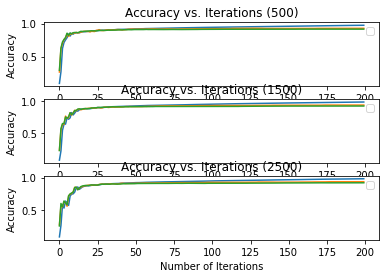

In [11]:
#1000 hidden units
#9 output nodes
#in_nodes = len(trainData) + 1
#out_nodes = 10

import time

trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

trainData = trainData.reshape((trainData.shape[0], 784))
trainData = np.insert(trainData, 0 ,np.ones(trainData.shape[0]), axis = 1)

validData = validData.reshape((-1, 784))
validData = np.insert(validData, 0 ,np.ones(validData.shape[0]), axis = 1)
testData = testData.reshape((-1, 784))
testData = np.insert(testData, 0 ,np.ones(testData.shape[0]), axis = 1)

###Convert one hot
TrainTarget, ValidTarget, TestTarget = convertOneHot(trainTarget, validTarget, testTarget)

Data = (trainData, validData, testData)
Target = (TrainTarget, ValidTarget, TestTarget)

n_x = trainData.shape[1]

#hidden layer units
n_y1 = 500 
n_y2 = 1500
n_y3 = 2500

#output layer
n_z = 10 

#standard deviation and hidden / out layers

#500
std1 = np.sqrt(2/(n_x + n_y1))
std2 = np.sqrt(2/(n_y1 + n_z))

w_hid1 = np.random.normal(loc = 0, scale = std1, size = (n_x, n_y1))
w_out1 = np.random.normal(loc = 0, scale = std2, size = (n_y1 + 1, n_z))

#1500
std3 = np.sqrt(2/(n_x + n_y2))
std4 = np.sqrt(2/(n_y2 + n_z))

w_hid2 = np.random.normal(loc = 0, scale = std3, size = (n_x, n_y2))
w_out2 = np.random.normal(loc = 0, scale = std4, size = (n_y2 + 1, n_z))

#2500
std5 = np.sqrt(2/(n_x + n_y3))
std6 = np.sqrt(2/(n_y3 + n_z))

w_hid3 = np.random.normal(loc = 0, scale = std5, size = (n_x, n_y3))
w_out3 = np.random.normal(loc = 0, scale = std6, size = (n_y3 + 1, n_z))

###
#parameters
num_iterations = 200 #200


###

#time start
time_start = time.time()

#train the network
#500
accuracy_train1, accuracy_valid1, accuracy_test1, dw_out1, dw_hid1, loss_train1, loss_valid1, loss_test1 = network_training(Data, Target,
                                                                     w_hid1, w_out1, 
                                                                     num_iterations, 1e-5, 0.9,  
                                                                     1e-5, 1e-5)
#1500
accuracy_train2, accuracy_valid2, accuracy_test2, dw_out2, dw_hid2, loss_train2, loss_valid2, loss_test2 = network_training(Data, Target,
                                                                     w_hid2, w_out2, 
                                                                     num_iterations, 1e-5, 0.9,  
                                                                     1e-5, 1e-5)
#2500
accuracy_train3, accuracy_valid3, accuracy_test3, dw_out3, dw_hid3, loss_train3, loss_valid3, loss_test3 = network_training(Data, Target,
                                                                     w_hid3, w_out3, 
                                                                     num_iterations, 1e-5, 0.9,  
                                                                     1e-5, 1e-5)

#time stop
time_stop = time.time()

#print time it took
print("Training Time: {}mins".format((time_stop - time_start) / 60))

#plot accuracy
###

#500
plt.figure()
plt.subplot(311)
plt.plot(accuracy_train1)
plt.plot(accuracy_valid1)
plt.plot(accuracy_test1)

acc_legend = plt.legend([accuracy_train1, accuracy_valid1, accuracy_test1], ["Train Acc.", "Valid Acc.", "Test Acc."])
plt.title("Accuracy vs. Iterations (500)")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")

#1500
plt.subplot(312)
plt.plot(accuracy_train2)
plt.plot(accuracy_valid2)
plt.plot(accuracy_test2)

acc_legend = plt.legend([accuracy_train2, accuracy_valid2, accuracy_test2], ["Train Acc.", "Valid Acc.", "Test Acc."])
plt.title("Accuracy vs. Iterations (1500)")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")

#2500
plt.subplot(313)
plt.plot(accuracy_train3)
plt.plot(accuracy_valid3)
plt.plot(accuracy_test3)

acc_legend = plt.legend([accuracy_train3, accuracy_valid3, accuracy_test3], ["Train Acc.", "Valid Acc.", "Test Acc."])
plt.title("Accuracy vs. Iterations (2500)")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy")


###
plt.show()


####### THIS IS THE SAME AS THE CELL PREVIOUS
#JUST PLOT THE CURVES WITH THE DIFFERENT HIDDEN NODES NUM
#DO THIS FOR 3 TRAININGS OF DIFFERENT NETWORKS WITH DIF NODE NUMS
#THEN RUN THE NETWORKS WITH TEST AND VALIDATION CURVES FOR EACH ONE
#WILL TAKE A LOT OF TIME, SO TEST WITH CELL ABOVE

Answer:

Validation accuracy after how many epochs training could be terminated early:

To prevent overfitting in neural networks, the location where the neural network should stop training can be determined by where the validation loss begins to increase while the training loss continues to decrease. 

This is around Epoch / Iteration #140 for the 500 hidden layer model. Validation loss seems to stagnate or oscillate around 1.556 while training loss still decreases. This can be determined to be the point of overfitting and a good time for early termination. 

This stagnation and oscillation doesn't seem to happen with the larger 1500 and 2500 model, though they both experience iterations where there are negligible increases in accuracy and negligible decreases in loss. Before these points occur would be suitable times for early termination to prevent overfitting. 

#######Results with 500 Hidden Units:#######
- Train Accuracy: 97.3800 % 
- Validation Accuracy: 92.8000 % 
- Test Accuracy: 91.5198 %
- Train Loss: 1.5222 
- Validation Loss: 1.5526
- Test Loss: 1.5624

Output:

Epoch: 199 of 200 || Train Accuracy: 97.3800 % || Validation Accuracy: 92.8000 % || Test Accuracy: 91.5198 %
Train Loss: 1.5222 || Validation Loss: 1.5526 || Test Loss: 1.5624


#######Results with 1500 Hidden Units:#######

- Train Accuracy: 98.1133 %
- Validation Accuracy: 93.4000 % 
- Test Accuracy: 91.9236 %
- Train Loss: 1.5166
- Validation Loss: 1.5486
- Test Loss: 1.5586

Output:

Epoch: 199 of 200 || Train Accuracy: 98.1133 % || Validation Accuracy: 93.4000 % || Test Accuracy: 91.9236 %
Train Loss: 1.5166 || Validation Loss: 1.5486 || Test Loss: 1.5586

#######Results with 2500 Hidden Units:#######

- Train Accuracy: 98.1133 %
- Validation Accuracy: 93.6000 % 
- Test Accuracy: 91.9971 %
- Train Loss: 1.5160
- Validation Loss: 1.5483
- Test Loss: 1.5589

Output:

Epoch: 199 of 200 || Train Accuracy: 98.1333 % || Validation Accuracy: 93.6000 % || Test Accuracy: 91.9971 %
Train Loss: 1.5160 || Validation Loss: 1.5483 || Test Loss: 1.5589

Please find the graphs attached to this repository if not being displayed here below.

Accuracy vs. Number of Iterations for 500, 1500, 2500 Hidden Nodes:

![accuracy_hyperparameters]("accuracy_hyperparameters.png")
(accuracy_hyperparameters.png)

Diagram: https://drive.google.com/open?id=1nrSENLA7Y1jhjoFUDSi5kaCMdPBCeDb-

Google Drive for Diagrams: https://drive.google.com/open?id=1hVfllsCnZKxbo9pf_uatfMKBwXMyhV4W


To Note: 
- Error in the graph view in output cell due to legend formatting error, but due to time was not able to fix graph formatting.
- Epoch 199 is actually epoch 200; it's just because I forgot to print i+1 when printing the text updates when i is indexed at 0. This does not change the value of any other parameter.

Total Training Time: 69.92189333836238 mins